It's one my practice component for writing difficult deep learning models using pytorch. I will be writing moe (mixture of experts) which is practically many experts condensed in one network and use a gating network to supply *x* token to *y* expert depending on which one is better at task *z*. I will be two MoE in this notebook: one super simple and another from Noam's 2017 paper

We're civil, start with simple one and then slaughter the fuck out of stupids with Noam

In [3]:
# doing imports 
import math 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 

In [4]:
def generate_data(n_samples=10000):
    X = torch.zeros(n_samples, 2) # each sample has 2 features 
    y = torch.zeros(n_samples, dtype=torch.long)
    
    ## Generate samples from two Gaussian Distributions
    X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3, 2])
    X[n_samples//2:] =  torch.randn(n_samples//2, 2) + torch.tensor([-3, 2])
    
    # labels
    for i in range(X.shape[0]):
        if X[i].norm() > math.sqrt(13):
            y[i] = 1 
    X[:, 1] = X[:, 1] - 2 
    return X, y

data, labels = generate_data()

In [5]:
data

tensor([[ 2.2098, -1.2904],
        [ 3.2438,  0.4633],
        [ 1.6047,  0.7710],
        ...,
        [-1.6408, -1.2480],
        [-5.1984,  1.3998],
        [-3.0876, -0.6628]])

We're going to plot the data

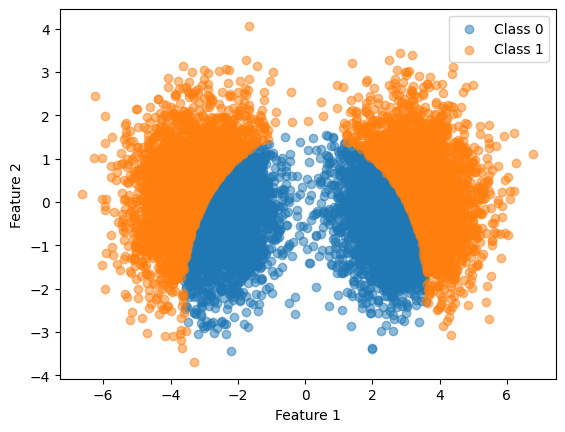

In [7]:
class_0 = data[labels == 0]
class_1 = data[labels == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], label='Class 0', alpha=0.5)
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.show()

Writing the expert model

In [13]:
class Expert(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, data):
        x = self.linear(data)
        return x 

Writing the Gating network

In [27]:
# this will output probab what expert to use 
class GatingNetwork(nn.Module):
    def __init__(self, input_size, num_experts):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 4)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(4, num_experts)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, data):
        x = self.linear1(data)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x 

In [47]:
class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts=2):
        super().__init__()
        self.expert1 = Expert(2, 1)
        self.expert2 = Expert(2, 1)
        self.gating = GatingNetwork(2, num_experts)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, data):
        expert1_output = self.expert1(data)
        expert2_output = self.expert2(data)
        
        gating_output = self.gating(data)
        
        mixed_output = gating_output[:, 0] * expert1_output.squeeze() + gating_output[:, 1] * expert2_output.squeeze()
        mixed_output_sigmoid = self.sigmoid(mixed_output)
        return mixed_output_sigmoid
    
    def backward(self, y_hat, labels, criterion, optimizer):
        optimizer.zero_grad()
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        return loss.item()

In [48]:
# training loop
moe = MixtureOfExperts()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(moe.parameters(), lr=0.01)

# convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# training loop 
num_epochs = 500
for epoch in tqdm(range(num_epochs)):
    y_hat = moe.forward(data)
    loss_value = moe.backward(y_hat, labels_tensor, criterion, optimizer)

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 500/500 [03:01<00:00,  2.76it/s]


In [49]:
## Decision boundaries
w11 = moe.expert1.linear.weight[0][0].detach()
w12 = moe.expert1.linear.weight[0][1].detach()

w21 = moe.expert2.linear.weight[0][0].detach()
w22 = moe.expert2.linear.weight[0][0].detach()

b1 = moe.expert1.linear.bias.detach()
b2 = moe.expert2.linear.bias.detach()

In [55]:
x_range = np.linspace(min(data[:,0]), max(data[:,0]))

y_line1 = -(w11 * x_range + b1) / w12 + 2.5
y_line2 = -(w21 * x_range + b2) / w22 + 2.5

x_line = x_range

class_0 = data[labels == 0]
class_1 = data[labels == 1]

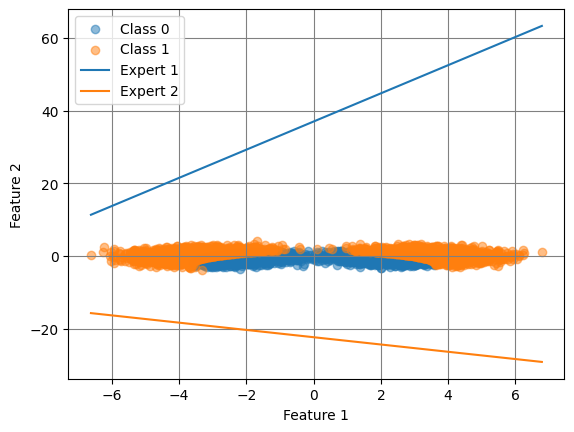

In [57]:
plt.scatter(class_0[:, 0], class_0[:, 1], label='Class 0', alpha=0.5)
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', alpha=0.5)

plt.plot(x_line, y_line1, label='Expert 1', alpha = 1)
plt.plot(x_line, y_line2, label='Expert 2', alpha = 1)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, c='gray')
plt.legend()
plt.autoscale()
plt.show()